# Emperical Dynamic Modeling Examples

Check out http://skedm.readthedocs.io/en/latest/ for a more complete introduction.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
import seaborn as sns
sns.set_style('ticks')
sns.set_context(context='paper',font_scale=1.3)
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# alter the line below to correspond to your file system
f = '../'
sys.path.append(f)

In [4]:
import skedm as edm
import skedm.data as data

# Regression Basic Example

#### Generate some data

# One Dimensional
First we are going to check out a one dimensional example. Here is what we are going to do:

1. Generate the time series
2. Calculate the mutual information of the time series
3. Embed the time series (not going to explore embedding dimension)
4. Train on the first 75% of the time series
5. Predict the last 25% over a range of near neighbors and forecast distances

### 1. Generate the time series

In [5]:
X = data.lorenz()[:,0] #only going to use the x values from the lorenz system

In [6]:
X.shape

(10000,)

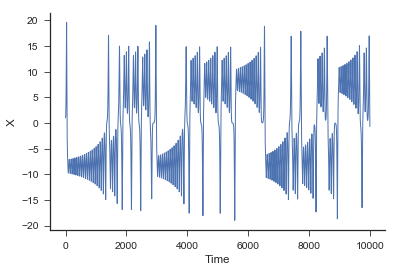

In [7]:
fig,ax = plt.subplots()
ax.plot(X,linewidth=1)
ax.set_xlabel('Time')
ax.set_ylabel('X')
sns.despine()

In [8]:
#fig.savefig('../figures/lorenz.png',bbox_inches='tight')

### 2. Calculate the mutual information of the time series

In [9]:
E = edm.Embed(X) #initiate the embed class

In [10]:
max_lag = 50
mi = E.mutual_information(max_lag)

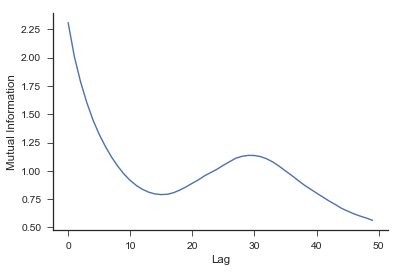

In [11]:
fig,ax=plt.subplots()
ax.plot(mi)
#ax.plot(mi2)
ax.set_xlabel('Lag')
ax.set_ylabel('Mutual Information')
sns.despine()

In [12]:
#fig.savefig('../figures/lorenz_mutual_info.png',bbox_inches='tight')

### 3. Embed the time series
First minimum of the mutual information is at 15, so we will take that as our lag.

In [13]:
lag = 15
embed = 3
predict = 36 #predicting out to double to lag
X,y = E.embed_vectors_1d(lag,embed,predict)

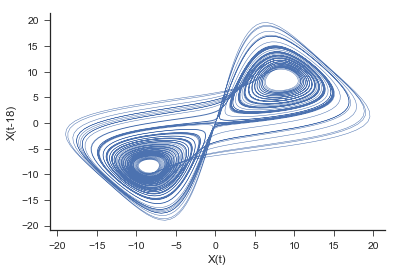

In [14]:
fig,ax = plt.subplots()
ax.plot(X[:,0],X[:,1],linewidth=.5)
ax.set_xlabel('X(t)')
ax.set_ylabel('X(t-18)')
sns.despine()

In [15]:
#fig.savefig('../figures/embedded_lorenz.png',bbox_inches='tight')

### 4. Train on the first 75% of the time series

In [16]:
#split it into training and testing sets
train_len = int(.75*len(X))
Xtrain = X[0:train_len]
ytrain = y[0:train_len]
Xtest = X[train_len:]
ytest = y[train_len:]

In [17]:
weights = 'distance' #use a distance weighting for the near neighbors
M = edm.Regression(weights) # initiate the nonlinear forecasting class

In [18]:
M.fit(Xtrain,ytrain) #fit the training data

### 5. Predict the last 25% of the time series

In [19]:
#NLF.dist_calc(Xtest) #calculate the distance all the near neighbors

In [20]:
nn_list = [10,100,300]
ypred = M.predict(Xtest,nn_list) #predictions using the 10 nearest neighbors

In [21]:
score = M.score(ytest) #score the predictions against the actual values

In [22]:
print(score.shape)
print(len(ypred))

(3, 36)
3


Plot up the prediction that is 36 time steps ahead and compare that to the actual evolution of the time series

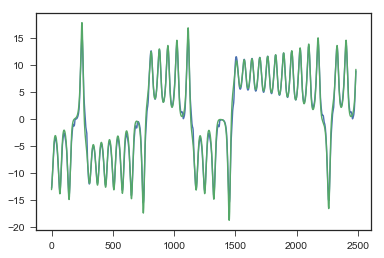

In [23]:
fig,ax = plt.subplots()
ax.plot(ypred[2][:,0])
ax.plot(ytest[:,0])

#### Check out the scores

In [24]:
score.shape

(3, 36)

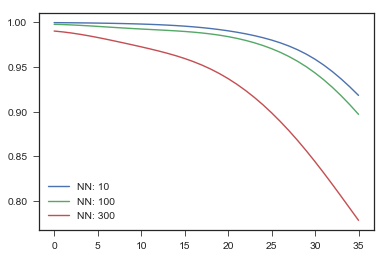

In [25]:
fig,ax = plt.subplots()

for i in range(3):
    label = 'NN: ' + str(nn_list[i]) 
    ax.plot(score[i,:],label=label)
    
plt.legend(loc='lower left')

#### Check the predictions for each near neighbor

In [26]:
nn_list = np.arange(1,7000,10)
ypred = M.predict_individual(Xtest,nn_list)
d_mean, d_std = M.dist_stats(nn_list)

In [27]:
score = M.score(ytest, how='corrcoef')

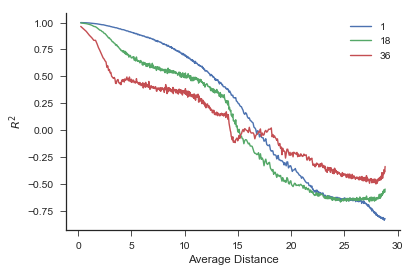

In [28]:
fig,ax = plt.subplots()
ax.plot(d_mean,score[:,0], label='1')
ax.plot(d_mean,score[:,17], label='18')
ax.plot(d_mean,score[:,35], label='36')
ax.legend()
sns.despine()
ax.set_ylabel('$R^2$')
ax.set_xlabel('Average Distance')

In [29]:
#fig.savefig('../figures/predict_individual_lorenz.png',bbox_inches='tight')

### 5a. Predict over a range of near neigbors
Takes roughly 30 seconds to run on a macbook air

# Two Dimensional Continuous
Here we are going to use the exact same procedure as we did for the one dimensional case.

1. Generate the 2D series
2. Calculate the mutual information of the 2D series
3. Embed the 2D series (not going to explore embedding dimension)
4. Train on the first 75% of the 2D series
5. Predict the last 25% over a range of near neighbors and forecast distances


### 1. Generate the 2D series

In [30]:
X = data.chaos_2d(sz=256)

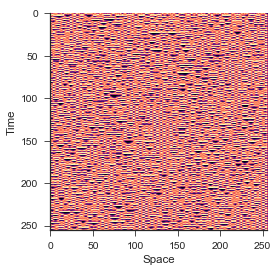

In [31]:
fig,ax = plt.subplots()
ax.imshow(X,cmap='magma')
ax.set_xlabel('Space')
ax.set_ylabel('Time')
sns.despine()

In [32]:
#fig.savefig('../figures/2d_chaos.png',bbox_inches='tight')

### 2. Calculate the mutual information of the series

In [33]:
E = edm.Embed(X)

In [34]:
rmi,cmi,rmut,cmut = E.mutual_information_spatial(30)

In [35]:
print(rmi.shape)
print(cmi.shape)
print(rmut.shape)
print(cmut.shape)

(30,)
(30,)
(128, 30)
(128, 30)


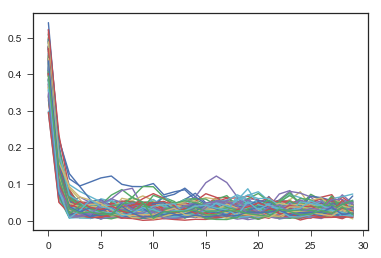

In [36]:
plt.plot(cmut.T);

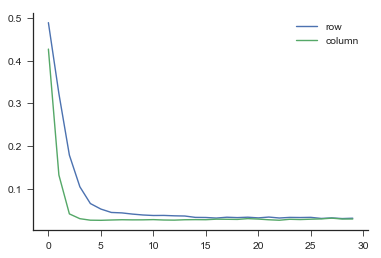

In [37]:
plt.plot(rmi,label='row')
plt.plot(cmi,label='column')
plt.legend()
sns.despine()

### 3. Embed the 2D series

Looks like the row has a mutual information minimum around 6 and the column has a minimum around 5.

In [38]:
lag = (4,2)
embed= (2,3)
predict = 7

X,y = E.embed_vectors_2d(lag,embed,predict)

targets before loop: (6254, 7)


### 4. Train on the first 75% of data

In [39]:
#split it into training and testing sets
train_len = int(.75*len(X))
Xtrain = X[0:train_len]
ytrain = y[0:train_len]
Xtest = X[train_len:]
ytest = y[train_len:]

In [40]:
weights = 'distance' #use a distance weighting for the near neighbors
M = edm.Regression(weights) # initiate the nonlinear forecasting class

In [41]:
M.fit(Xtrain,ytrain) #fit the training data

### 5. Predict the last 25% of the data

In [42]:
nn_list = [10]
ypred = M.predict(Xtest,nn_list) #predictions using the 10 nearest neighbors
score = M.score(ytest) #score the predictions against the actual values

In [43]:
print(score.shape)
print(len(ypred))

(1, 7)
1


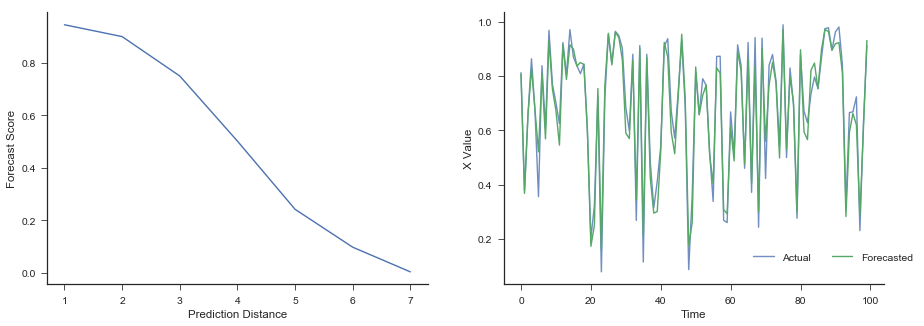

In [44]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.arange(1,8),score.ravel())
ax[0].set_xlabel('Prediction Distance')
ax[0].set_ylabel('Forecast Score')

ax[1].plot(ytest[0:100,0],label='Actual',alpha=.8);
ax[1].plot(ypred[0][0:100,0],label='Forecasted');
ax[1].set_xlabel('Time')
ax[1].set_ylabel('X Value')
ax[1].legend(bbox_to_anchor=(1.1, .15),ncol=2)
sns.despine()

In [45]:
#fig.savefig('../figures/2d_chaos_forecast.png',bbox_inches='tight')

### 5a. Predict over a range of near neighbors

In [46]:
nn_list = np.arange(1,200,10,dtype='int')
preds = M.predict(Xtest,nn_list)

In [47]:
s_range = M.score(ytest)

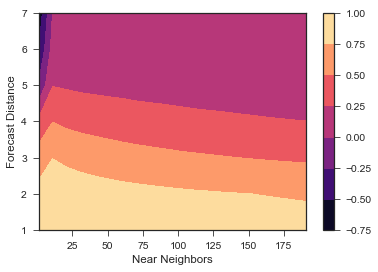

In [48]:
fig,ax = plt.subplots()
cax = ax.contourf(nn_list,np.arange(1,8),s_range.T,cmap='magma');
ax.set_xlabel('Near Neighbors')
ax.set_ylabel('Forecast Distance')
fig.colorbar(cax);

## Predict Individaul

In [49]:
preds = M.predict_individual(Xtest,nn_list)
s_range = M.score(ytest)

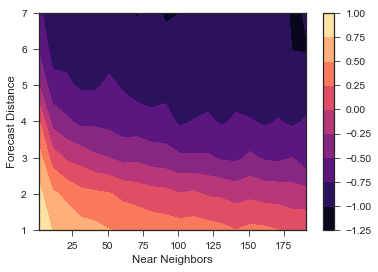

In [50]:
fig,ax = plt.subplots()
cax = ax.contourf(nn_list,np.arange(1,8),s_range.T,cmap='magma');
ax.set_xlabel('Near Neighbors')
ax.set_ylabel('Forecast Distance')
fig.colorbar(cax);

# Two Dimensional - Discrete
Again we are going to use the exact same procedure.

1. Generate the 2D discrete image
2. Calculate the mutual information of the 2D image
3. Embed the 2D image (not going to explore embedding dimension)
4. Train on the first 75% of the 2D image
5. Predict the last 25% over a range of near neighbors and forecast distances

### 1. Generate the 2D discrete image

In [51]:
X = data.voronoi_matrix(percent=.01)

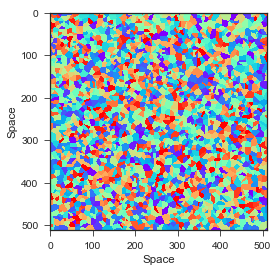

In [52]:
fig,ax = plt.subplots()
ax.imshow(X,interpolation='none',cmap='rainbow')
ax.set_ylabel('Space')
ax.set_xlabel('Space')

In [53]:
#fig.savefig('../figures/2d_voronoi.png',bbox_inches='tight')

### 2. Calculate the mutual information

In [54]:
E = edm.Embed(X)

In [55]:
mi = E.mutual_information_spatial(50,digitize=False)

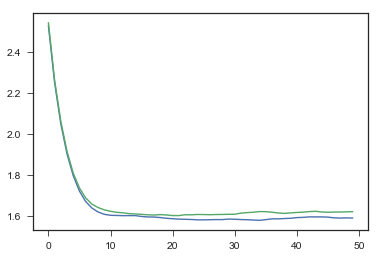

In [56]:
plt.plot(mi[0]);
plt.plot(mi[1]);

### 3. Embed the 2D image

In [57]:
lag = (8,8)
emb = (2,2)
predict = 8
X,y = E.embed_vectors_2d(lag,emb,predict,percent=.02)

targets before loop: (5011, 8)


### 4. Train on 75% of the image

In [58]:
#split it into training and testing sets
train_len = int(.75*len(X))
Xtrain = X[0:train_len]
ytrain = y[0:train_len]
Xtest = X[train_len:]
ytest = y[train_len:]

In [59]:
weights = 'distance' #use a distance weighting for the near neighbors
M = edm.Classification(weights) # initiate the nonlinear forecasting class

In [60]:
M.fit(Xtrain,ytrain) #fit the training data

### Predict the last 25% of the image

In [61]:
nn_list = [5]
ypred = M.predict(Xtest,nn_list) #predictions using the 10 nearest neighbors
score = M.score(ytest) #score the predictions against the actual values

In [62]:
print(score.shape)
print(len(ypred))

(1, 8)
1


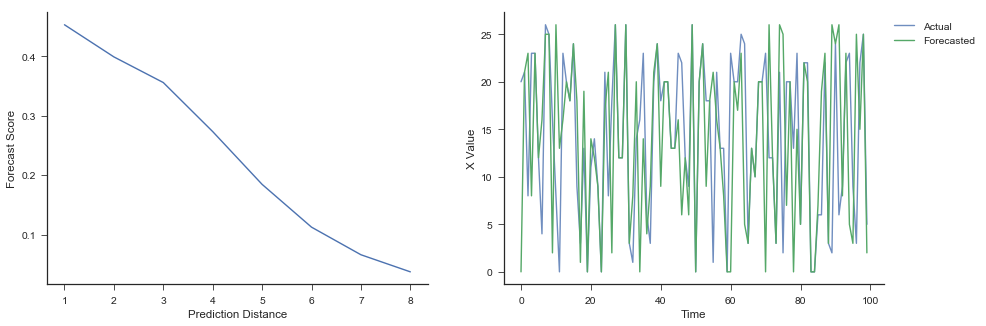

In [63]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.arange(1,9),score.ravel())
ax[0].set_xlabel('Prediction Distance')
ax[0].set_ylabel('Forecast Score')

ax[1].plot(ytest[0:100,0],label='Actual',alpha=.8);
ax[1].plot(ypred[0][0:100,0],label='Forecasted');
ax[1].set_xlabel('Time')
ax[1].set_ylabel('X Value')
ax[1].legend(bbox_to_anchor=(1., 1.),ncol=1)
sns.despine()

In [64]:
#fig.savefig('../figures/2d_voronoi_forecast.png',bbox_inches='tight')

### 5a. Predict over a range of Near Neighbors

In [65]:
len(Xtest)

1253

In [66]:
nn_list = np.arange(1,len(Xtest),100,dtype='int')
preds = M.predict(Xtest,nn_list)

In [67]:
s_range = M.score(ytest)

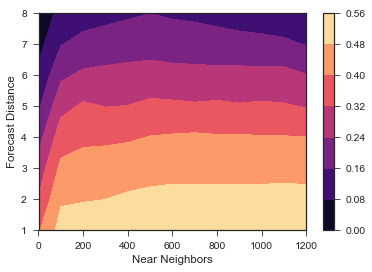

In [68]:
fig,ax = plt.subplots()
cax = ax.contourf(nn_list,np.arange(1,9),s_range.T,cmap='magma');
ax.set_xlabel('Near Neighbors')
ax.set_ylabel('Forecast Distance')
fig.colorbar(cax);

## Predict Individual

In [69]:
preds = M.predict_individual(Xtest,nn_list)
s_range = M.score(ytest)

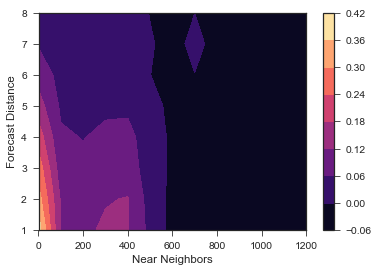

In [70]:
fig,ax = plt.subplots()
cax = ax.contourf(nn_list,np.arange(1,9),s_range.T,cmap='magma');
ax.set_xlabel('Near Neighbors')
ax.set_ylabel('Forecast Distance')
fig.colorbar(cax);

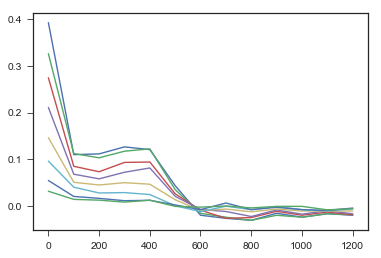

In [71]:
plt.plot(nn_list,s_range);

# Different Levels of Noise

In [72]:
noise_levels = np.linspace(0,.2,6)
D = []
for noise in noise_levels:
    
    D.append(data.logistic_map(sz=512) + np.random.randn(512)*noise) 

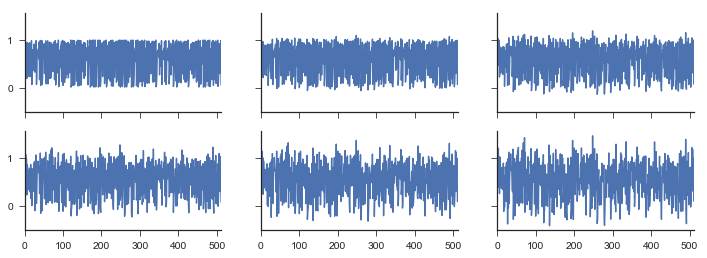

In [73]:
fig,axes = plt.subplots(2,3,figsize=(12,4),sharex=True,sharey=True)

for ax,ts in zip(axes.ravel(),D):
    
    ax.plot(ts)
    ax.set_xlim(0,512)
sns.despine()

In [74]:
E = edm.Embed(D[0]) #initiate the embed class
max_lag = 10
mi = E.mutual_information(max_lag)

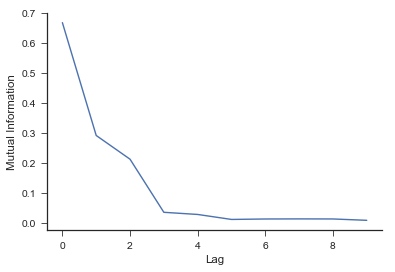

In [75]:
fig,ax=plt.subplots()
ax.plot(mi)
#ax.plot(mi2)
ax.set_xlabel('Lag')
ax.set_ylabel('Mutual Information')
sns.despine()

In [76]:
lag = 2
embed = 2
predict = 4 #predicting out to double to lag
X,y = E.embed_vectors_1d(lag,embed,predict)

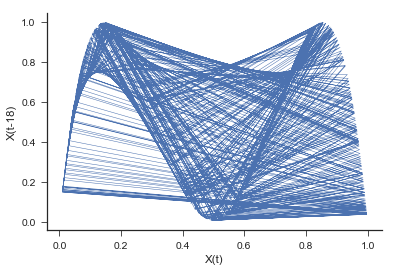

In [77]:
fig,ax = plt.subplots()
ax.plot(X[:,0],X[:,1],linewidth=.5)
ax.set_xlabel('X(t)')
ax.set_ylabel('X(t-18)')
sns.despine()

In [78]:
nn_list = np.arange(1,50)
lag = 2
embed = 2
predict = 4 #predicting out to double to lag

preds = []
scores = []
dists = []

In [79]:

for ts in D:
    
    E = edm.Embed(ts) #initiate the embed class
    X,y = E.embed_vectors_1d(lag,embed,predict)

    #split it into training and testing sets
    train_len = int(.75*len(X))
    Xtrain = X[0:train_len]
    ytrain = y[0:train_len]
    Xtest = X[train_len:]
    ytest = y[train_len:]

    M = edm.Regression() # initiate the nonlinear forecasting class
    M.fit(Xtrain,ytrain) #fit the training data

    pred = M.predict_individual(Xtest, nn_list)
    scores.append( M.score(ytest,how='corrcoef') )
    dists.append( M.dist_stats(nn_list))

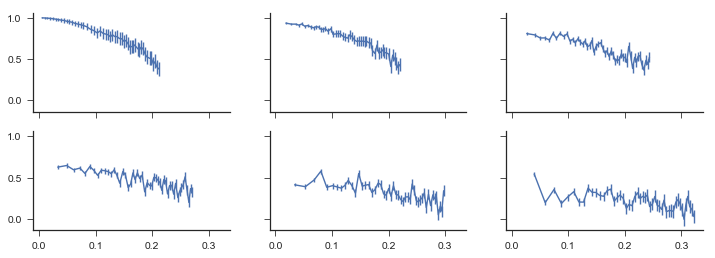

In [80]:
fig,axes = plt.subplots(2,3,figsize=(12,4),sharex=True,sharey=True)

for ax,s,d in zip(axes.ravel(),scores,dists):
    
    ax.errorbar(d[0],s[:,0],yerr=d[1])
sns.despine()

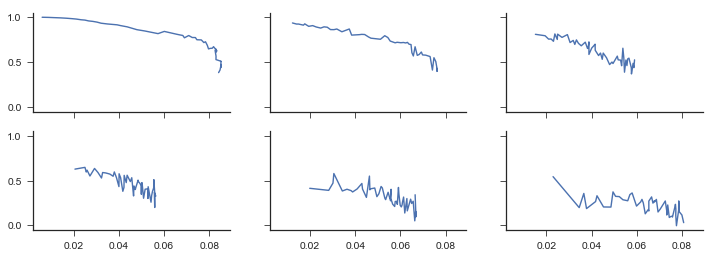

In [81]:
fig,axes = plt.subplots(2,3,figsize=(12,4),sharex=True,sharey=True)

for ax,s,d in zip(axes.ravel(),scores,dists):
    
    ax.plot(d[1],s[:,0])
sns.despine()